In [458]:
using LinearAlgebra, Statistics
using LaTeXStrings, Plots, Interpolations, NLsolve, Optim, Random, GLM #, JuMP, GLM, Ipopt
using Optim: maximum, maximizer

using CSV, DataFrames

pwt_usa = CSV.read("../Data/PWT_USA.csv", DataFrame)
first(pwt_usa, 5)
# println("Data loaded successfully.")

Row,countrycode,country,currency_unit,year,pop,rgdpo,rgdpe,cgdpo,cgdpe,ccon,cda,ck,ctfp,cwtfp,rgdpo_pc,rgdpe_pc,cgdpo_pc,cgdpe_pc,ccon_pc,cda_pc,ck_pc,invest
,String3,String15,String15,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,USA,United States,US Dollar,1950,155.564,2.2742e6,2.27979e6,2.27281e6,2.27598e6,1.74436e6,2.26991e6,5.86108e6,1.0,1.0,14619.1,14655.0,14610.2,14630.5,11213.1,14591.5,37676.4,5.25557e5
2,USA,United States,US Dollar,1951,158.227,2.44382e6,2.44008e6,2.45624e6,2.45257e6,1.83799e6,2.43421e6,6.32564e6,1.0,1.0,15445.0,15421.4,15523.5,15500.3,11616.2,15384.3,39978.3,5.96224e5
3,USA,United States,US Dollar,1952,160.96,2.52641e6,2.53052e6,2.55437e6,2.55683e6,1.92676e6,2.54918e6,6.74338e6,1.0,1.0,15695.9,15721.5,15869.6,15884.9,11970.5,15837.4,41894.8,6.22418e5
4,USA,United States,US Dollar,1953,163.648,2.64298e6,2.65528e6,2.67583e6,2.68358e6,2.03099e6,2.68771e6,6.99867e6,1.0,1.0,16150.4,16225.6,16351.1,16398.5,12410.8,16423.8,42766.7,6.56716e5
5,USA,United States,US Dollar,1954,166.551,2.6338e6,2.64087e6,2.65925e6,2.66224e6,2.03522e6,2.6602e6,7.14076e6,1.0,1.0,15813.8,15856.2,15966.6,15984.5,12219.8,15972.3,42874.3,6.24972e5


### Project Goal  

Our primary aim is to study **“Optimal Growth I: The Stochastic Optimal Growth Model”** using U.S. economic data and compare the model’s implications with real observations.

We will follow the framework implemented in *optgrowth.ipynb* from the Julia QuantEcon notebooks.  
To carry out estimation, optimization, and simulation tasks, we make use of several Julia packages, including **NLSolve**, **Optim**, **GLM**, and other standard libraries.

In the next section, we provide a brief overview of the model structure and its economic interpretation.
 

## The Model


<a id='index-1'></a>
Consider an agent (**The USA**) who owns an amount $ y_t \in \mathbb R_+ := [0, \infty) $ of a consumption good at time $ t $ (**real GDP on output side**).

This output can either be consumed or invested.

When the good is invested it is transformed one-for-one into capital (for capital, we can directly consider **capital stock** data or calculate the **investment = absobption - consumption**).

The resulting capital stock, denoted here by $ k_{t+1} $, will then be used for production.

Production is stochastic, in that it also depends on a shock $ \xi_{t+1} $ realized at the end of the current period.

Next period output is

$$
y_{t+1} := f(k_{t+1}) \xi_{t+1}
$$

where $ f \colon \mathbb{R}_+ \to \mathbb{R}_+ $ is called the production function. We will use **Cobb-Douglas fitting** for production function and **GDP vs capital stock** data to model the function. More on this later.

The resource constraint is


<a id='equation-outcsdp0'></a>
$$
k_{t+1} + c_t \leq y_t \tag{1}
$$

and all variables are required to be nonnegative.

## Cobb–Douglas Production Function

A standard Cobb–Douglas production model is:

$$
f(k) = A k^{\alpha}
$$

- **\(A\)** (Total Factor Productivity): Captures economy-wide efficiency. Higher \(A\) means the same capital produces more output.
- **\($\alpha$\)** (Capital Share of Output): Measures how strongly capital contributes to output. Higher \(\alpha\) means output is more sensitive to capital accumulation.

**Reference:**  
[Cobb–Douglas production function: Wikipedia](https://en.wikipedia.org/wiki/Cobb%E2%80%93Douglas_production_function)


In [459]:
df_y_k = pwt_usa[:, [:year, :rgdpo_pc, :ck_pc, :pop, :ccon_pc]]
first(df_y_k, 5)

Row,year,rgdpo_pc,ck_pc,pop,ccon_pc
,Int64,Float64,Float64,Float64,Float64
1,1950,14619.1,37676.4,155.564,11213.1
2,1951,15445.0,39978.3,158.227,11616.2
3,1952,15695.9,41894.8,160.96,11970.5
4,1953,16150.4,42766.7,163.648,12410.8
5,1954,15813.8,42874.3,166.551,12219.8


In [460]:
df_y_k.log_y = log.(df_y_k.rgdpo_pc)
df_y_k.log_k = log.(df_y_k.ck_pc)
first(df_y_k, 5)

model = lm(@formula(log_y ~ log_k), df_y_k)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

log_y ~ 1 + log_k

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.422953   0.154929    2.73    0.0082   0.113351   0.732555
log_k        0.870565   0.0136463  63.79    <1e-58   0.843295   0.897835
────────────────────────────────────────────────────────────────────────

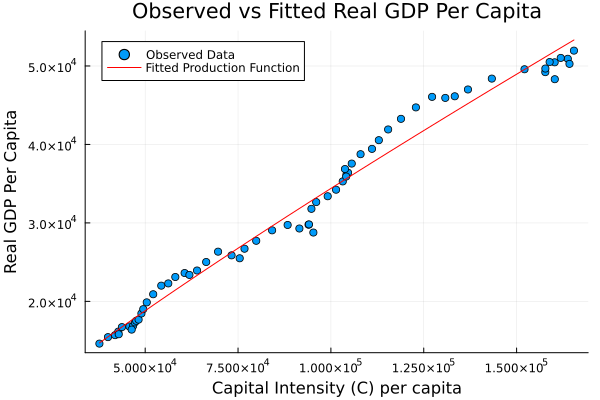

In [461]:
α = coef(model)[2]
A_val = exp(coef(model)[1])
f_cd(k) = A_val * k^α

df_y_k.fitted = f_cd.(df_y_k.ck_pc)

scatter(
    df_y_k.ck_pc, df_y_k.rgdpo_pc,
    label="Observed Data",
    xlabel="Capital Intensity (C) per capita",
    ylabel="Real GDP Per Capita",
    title="Observed vs Fitted Real GDP Per Capita"
)

plot!(
    df_y_k.ck_pc, df_y_k.fitted,
    label="Fitted Production Function",
    lw=1,
    lc=:red
)

### Optimization

Taking $ y_0 $ as given, the agent wishes to maximize the **Social Welfare Function**


<a id='equation-texs0-og2'></a>
$$
\mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(c_t) \right] \tag{2}
$$

subject to


<a id='equation-og-conse'></a>
$$
y_{t+1} = f(y_t - c_t) \xi_{t+1}
\quad \text{and} \quad
0 \leq c_t \leq y_t
\quad \text{for all } t \tag{34.3}
$$

where

- $ u $ is a bounded, continuous and strictly increasing utility function and  
- $ \beta \in (0, 1) $ is a discount factor  

We will use [Isoelastic utility functions](https://en.wikipedia.org/wiki/Isoelastic_utility) as our utility functions. These are modelled as

$$
u(c) = \begin{cases}
        \frac{c^{1-\eta}-1}{1-\eta} &\eta \geq 0,\ \eta \neq 1\\
        \ln(c) &\eta = 1
    \end{cases}
$$
- $\eta$ close to zero means risk neutrality
- $\eta$ close to one means utilitarian welfare function
- Large $\eta$ means risk aversion.


The discount factor $\beta$ models the [time preference](https://en.wikipedia.org/wiki/Time_preference) of the agent: The current relative valuation placed on receiving a good at an earlier date compared with receiving it at a later date. Higer $\beta$ value (close to 1) means the agent values the future as much as the present whereas lower $\beta$ value (close to 0) means the economy is consumption heavy. 



## Policy function 

In our context, a Markov policy is a function $ \sigma \colon
\mathbb R_+ \to \mathbb R_+ $, with the understanding that states are mapped to actions via

$$
c_t = \sigma(y_t) \quad \text{for all } t
$$


The **policy value function** $ v_{\sigma} $ associated with a given policy $ \sigma $ is the mapping defined by


<a id='equation-vfcsdp00'></a>
$$
v_{\sigma}(y) = \mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(\sigma(y_t)) \right] \tag{3}
$$


In other words, it is the lifetime value of following policy $ \sigma $
starting at initial condition $ y $.

The **value function** is then defined as


<a id='equation-vfcsdp0'></a>
$$
v^*(y) := \sup_{\sigma \in \Sigma} \; v_{\sigma}(y) \tag{4}
$$

The value function gives the maximal value that can be obtained from state $ y $, after considering all feasible policies.

A policy $ \sigma \in \Sigma $ is called **optimal** if it attains the supremum in [(4)](#equation-vfcsdp0) for all $ y \in \mathbb R_+ $.

### The Bellman Equation and Bellman Operator

With our assumptions on utility and production function, the value function as defined in [(4)](#equation-vfcsdp0) also satisfies a **Bellman equation**.

For this problem, the Bellman equation takes the form


<a id='equation-fpb30'></a>
$$
w(y) = \max_{0 \leq c \leq y}
    \left\{
        u(c) + \beta \int w(f(y - c) z) \phi(dz)
    \right\}
\qquad (y \in \mathbb R_+) \tag{5}
$$

This is a *functional equation in* $ w $.

How, then, should we compute the value function?

One way is to use the so-called **Bellman operator**.

(An operator is a map that sends functions into functions)

The Bellman operator is denoted by $ T $ and defined by


<a id='equation-fcbell20-optgrowth'></a>
$$
Tw(y) := \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int w(f(y - c) z) \phi(dz)
\right\}
\qquad (y \in \mathbb R_+) \tag{34.11}
$$

In other words, $ T $ sends the function $ w $ into the new function
$ Tw $ defined [(34.11)](#equation-fcbell20-optgrowth).

By construction, the set of solutions to the Bellman equation [(5)](#equation-fpb30) *exactly coincides with* the set of fixed points of $ T $.

For example, if $ Tw = w $, then, for any $ y \geq 0 $,

$$
w(y)
= Tw(y)
= \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int v^*(f(y - c) z) \phi(dz)
\right\}
$$

which says precisely that $ w $ is a solution to the Bellman equation.

It follows that $ v^* $ is a fixed point of $ T $.



To find this fixed point, we will generate iterated sequence $w, Tw, Tw^2, ...$ with a good enough starting point $w$. (Note that $w$ is a function and not a vector, so we can not compute it).

For the computation, we will do instead is use **fitted value function iteration**.

The procedure is to record the value of the function $ Tw $ at only finitely many “grid” points $ y_1 < y_2 < \cdots < y_I $ and reconstruct it from this information when required.

More precisely, the algorithm will be


<a id='fvi-alg'></a>
1. Begin with an array of values $ \{ w_1, \ldots, w_I \} $ representing the values of some initial function $ w $ on the grid points $ \{ y_1, \ldots, y_I \} $.  
1. Build a function $ \hat w $ on the state space $ \mathbb R_+ $ by interpolation or approximation, based on these data points.  
1. Obtain and record the value $ T \hat w(y_i) $ on each grid point $ y_i $ by repeatedly solving [(34.11)](#equation-fcbell20-optgrowth).  
1. Unless some stopping condition is satisfied, set $ \{ w_1, \ldots, w_I \} = \{ T \hat w(y_1), \ldots, T \hat w(y_I) \} $ and go to step 2.  


How should we go about step 2?

This is a problem of function approximation, and there are many ways to approach it. We will use linear interpolation.


In [462]:
function T(w; p, tol = 1e-10)
    (; beta, u, f, Xi, y) = p # unpack parameters
    w_func1 = LinearInterpolation(y, w)
    
    w_func(t) = (t < minimum(y)) ? minimum(w) : (t > maximum(y) ? maximum(w) : w_func1(t))

    Tw = similar(w)
    sigma = similar(w)
    y_min = minimum(y)
    
    
    for (i, y_val) in enumerate(y)
        # solve maximization for each point in y, using y itself as initial condition.
        results = maximize(c -> u(c; p) +
                                beta * mean(w_func.(f(y_val - c; p) .* Xi)),
                           tol, y_val)
        
        Tw[i] = maximum(results)
        sigma[i] = maximizer(results)
    end
    return (; w = Tw, sigma) # returns named tuple of results
end

T (generic function with 1 method)

In [463]:
Random.seed!(42) # for reproducible results
u(c; p) = ((c^0.5) - 1) / 0.5 #log(c) # utility
f(k; p) = p.A * k^p.alpha # deterministic part of production function

function OptimalGrowthModel(; A = A_val, alpha = α, beta = 0.95, mu = 0.0, s = 0.1,
                            u = u, f = f, # defaults defined above
                            y = range(1e-5, 5*10^4 , length = 200), # grid on y
                            Xi = exp.(mu .+ s * randn(250)))
    return (; A, alpha, beta, mu, s, u, f, y, Xi)
end # named tuples defaults

OptimalGrowthModel (generic function with 1 method)

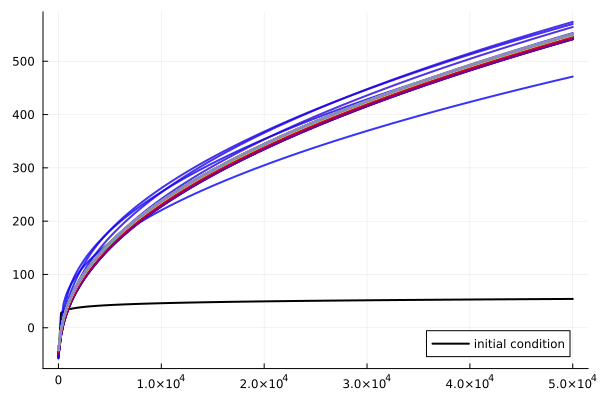

In [464]:
w = 5 * log.(p.y)  # An initial condition -- fairly arbitrary
n = 35

plot()
lb = "initial condition"
plt = plot(p.y, w, color = :black, linewidth = 2, label = lb)


for i in 1:100
    w = T(w; p).w
    # println("Iteration $i completed.")
    plot!(p.y, w, color = RGBA(i / n, 0, 1 - i / n, 0.8), linewidth = 2, label = "")
end

plot!(plt, legend = :bottomright)

In [465]:
function solve_optgrowth(initial_w; p, iterations = 500, m = 3,
                         show_trace = false)
    results = fixedpoint(w -> T(w; p).w, initial_w; iterations, m, show_trace) # Anderson iteration
    v_star = results.zero
    sigma = T(results.zero; p).sigma
    return (; v_star, sigma, results)
end

solve_optgrowth (generic function with 1 method)

In [466]:
initial_w = 5 * log.(p.y)
sol = solve_optgrowth(initial_w; p)
print(sol)
v_star_approx = sol.v_star
println("Converged in $(sol.results.iterations) iterations to an ||residuals||_∞ of $(sol.results.residual_norm)")


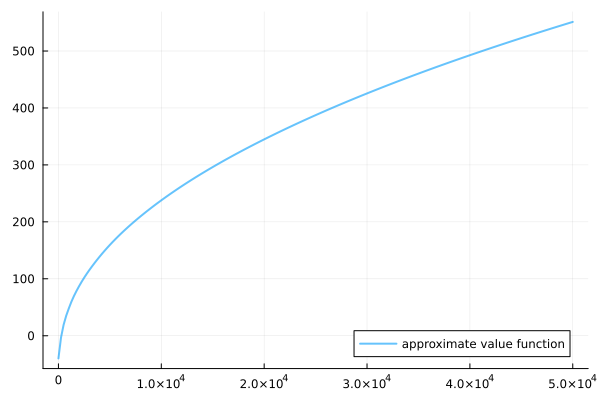

In [467]:

plt = plot()
plot!(plt, p.y, v_star_approx, linewidth = 2, alpha = 0.6,
      label = "approximate value function")

plot!(plt, legend = :bottomright)

## Extract the policy function

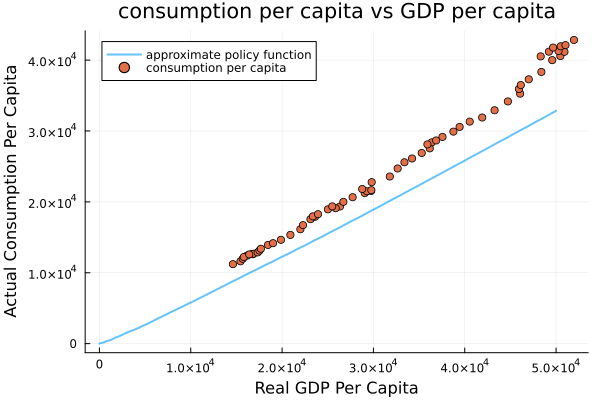

In [468]:
plt = plot(p.y, T(v_star_approx; p).sigma, lw = 2, alpha = 0.6,
           label = "approximate policy function")
scatter!(
    df_y_k.rgdpo_pc, df_y_k.ccon_pc,
    title="consumption per capita vs GDP per capita",
    label="consumption per capita",
    xlabel="Real GDP Per Capita", ylabel="Actual Consumption Per Capita"
)
plot!(plt, legend = :topleft)

# savefig(plt, "../Plots/policy_function_eta_05.png")

In [469]:
etavals = [0.1, 0.3, 0.5, 0.7, 0.9]

for eta in etavals
    u(c; p) = ((c^(1 - eta)) - 1) / (1 - eta) # CRRA utility
    p = OptimalGrowthModel(u = u)
    initial_w = 5 * log.(p.y)
    sol = solve_optgrowth(initial_w; p)
    v_star_approx = sol.v_star
    plt = plot(p.y, T(v_star_approx; p).sigma, lw = 2, alpha = 0.6,
               label = "approximate policy function (eta=$(eta))")
    scatter!(
        df_y_k.rgdpo_pc, df_y_k.ccon_pc,
        title="consumption per capita vs GDP per capita",
        label="consumption per capita",
        xlabel="Real GDP Per Capita", ylabel="Actual Consumption Per Capita"
    )
    plot!(plt, legend = :topleft)
    savefig(plt, "../Plots/policy_function_eta_$(Int(eta*10)).png")
end